# Add auto-regulation to species

This notebook tries to verify the idea that
$$
\rho \geq \sqrt{\min(N_S/N_R, N_R/N_S)},
$$
is the stability criterion.

In [24]:
import numpy as np
import matplotlib.pyplot as plt

First sample communities with constant resource supply.

In [25]:
Ns = 16
Nr = 32
rho = .99

Tgc = np.random.randn(2, Ns, Nr)

G = Tgc[0]
C = rho * Tgc[0] + np.sqrt(1-rho**2) * Tgc[1]
G = G + 2.0
C = C + 2.0
Ss = 0.01 + 0.99*np.random.rand(Ns)
Rs = 0.01 + 0.99*np.random.rand(Nr)
g = 0.1 + 0.9*np.random.rand(Nr)
#Rs = np.ones(Nr)
#g = np.ones(Nr) * Ns # must scale up to get stability!!

Js = np.zeros((Ns+Nr,Ns+Nr))
Js[0:Ns,Ns:Ns+Nr] = G #np.diag(Ss) @ G
Js[Ns:Ns+Nr,0:Ns] = - C.T #- np.diag(Rs) @ C.T
#Js[Ns:Ns+Nr,Ns:Ns+Nr] = - np.diag(C.T @ Ss)
#Js[Ns:Ns+Nr,Ns:Ns+Nr] = - np.diag(g * Rs)

E_J = np.linalg.eigvals(Js)

Text(0, 0.5, 'Imag')

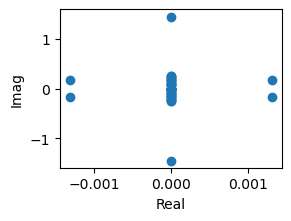

In [26]:
plt.figure(figsize=(2.8, 2.1), constrained_layout=True)
plt.scatter(E_J.real/Nr, E_J.imag/Nr)
plt.xlabel('Real')
plt.ylabel('Imag')

Trial finished. A function for sampling as follows.

In [27]:
def sample(Ns:int,
           Nr:int,
           rho:float,
           a0 = 1,
           a1 = 1):
    
       Tgc = np.random.randn(2, Ns, Nr)

       G = Tgc[0]
       C = rho * Tgc[0] + np.sqrt(1-rho**2) * Tgc[1]
       G = (G + 2.0) / Nr
       C = (C + 2.0) / Nr
       Ss = (0.01 + 0.99*np.random.rand(Ns)) * Nr / Ns  # or scale this down
       Rs = 0.01 + 0.99*np.random.rand(Nr)
       g = (0.1 + 0.9*np.random.rand(Nr)) * a0
       gs = (0.1 + 0.9*np.random.rand(Ns)) * a1 # this is the key for v12, add auto-regulation for species
       #Rs = np.ones(Nr)
       #g = np.ones(Nr) * Ns # must scale up to get stability!!

       Js = np.zeros((Ns+Nr,Ns+Nr))
       Js[0:Ns,Ns:Ns+Nr] = np.diag(Ss) @ G
       Js[Ns:Ns+Nr,0:Ns] = - np.diag(Rs) @ C.T
       #Js[Ns:Ns+Nr,Ns:Ns+Nr] = - np.diag(C.T @ Ss)
       Js[Ns:,Ns:] = - np.diag(g * Rs)
       Js[:Ns,:Ns] = - np.diag(gs * Ss)

       E_J = np.linalg.eigvals(Js)
       E_Jr = E_J.real
       NU_J = len(E_Jr[E_Jr >= 1.0e-7]) # if devided by Nr or Ns

       return NU_J

Want to draw a figure with x-axis being $N_S/N_R$ and y-axis being $\rho$. The color map is number of unstable mode?

In [28]:
rho_span = np.arange(0.005,1.0,0.01)
Nr = 32
Ns_span = range(1,128)

NU = np.zeros((len(Ns_span), len(rho_span), 10))
for i in range(len(Ns_span)):
    Ns = Ns_span[i]
    for j in range(len(rho_span)):
        rho = rho_span[j]
        # each point sample 10 communities
        for k in range(0,10):
            NU[i,j,k] = sample(Ns, Nr, rho, a1 = .05)

NU_mean = np.mean(NU, -1)

In [29]:
FNC = np.mean((NU > 0).astype(float), -1)

In [30]:
NU_draw = np.zeros(np.shape(NU_mean))
FNC_draw = np.zeros(np.shape(NU_mean))
for j in range(100):
    NU_draw[:,j] = NU_mean[:,100-j-1]
    FNC_draw[:,j] = FNC[:,100-j-1]

In [31]:
def criterion(x):
    # x is Ns/Nr array
    y = np.minimum(np.sqrt(x), np.sqrt(1/x))
    return y

xdraw = np.linspace(1/32, 4)
ydraw = criterion(xdraw)

In [32]:
def criterion1(x):
    # x is Ns/Nr array
    y = np.sqrt(np.maximum(0, 1 - 2 *0.03 * np.sqrt(1 + 1/x) / x))
    return y

xdraw1 = np.linspace(1/32, 4)
ydraw1 = criterion1(xdraw1)

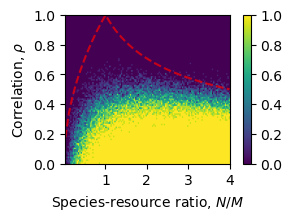

In [33]:
plt.figure(figsize=(2.8, 2.1), constrained_layout=True)
extent = 1/32, 4, 0, 1
plt.imshow(FNC_draw.T, extent=extent, aspect=3.6)
plt.colorbar()
plt.plot(xdraw, ydraw, '--r',alpha = 0.7)
#plt.scatter([12/32,1.0,3.0],[0.8 for i in range(3)],c='r')
plt.xticks([1,2,3,4])

plt.xlabel('Species-resource ratio, $N/M$')
plt.ylabel(r'Correlation, $\rho$')
plt.savefig('../figures/autoregulation.pdf')

Text(0, 0.5, 'Correlation, $\\rho$')

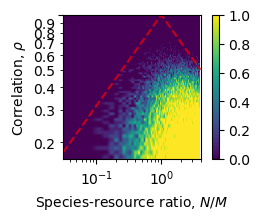

In [34]:
plt.figure(figsize=(2.8, 2.1), constrained_layout=True)
extent = 1/32, 4, 0, 1
plt.imshow(FNC_draw.T, extent=extent, aspect=2.8)
plt.colorbar()
plt.plot(xdraw, ydraw, '--r',alpha = 0.7)
#plt.scatter([12/32,1.0,3.0],[0.8 for i in range(3)],c='r')

plt.xscale('log')
plt.yscale('log')

#plt.xticks([1,2,3,4])
#plt.yticks([0.1,0.5,0.7,1])
import matplotlib.ticker as mticker
ax=plt.gca()
ax.yaxis.set_major_formatter(mticker.NullFormatter())
ax.yaxis.set_minor_formatter(mticker.StrMethodFormatter('{x:.1f}'))

plt.xlabel('Species-resource ratio, $N/M$')
plt.ylabel(r'Correlation, $\rho$')

Need to try for $M = 32$, do that in exp :)